In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

C:\Users\abhis\anaconda3\envs\directml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

TensorShape([Dimension(500), Dimension(500), Dimension(1)])


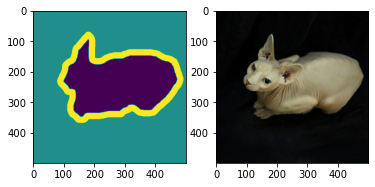

In [3]:

for d in dataset['train']:
#     tf.print(d['segmentation_mask'])
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(d['segmentation_mask']))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(d['image']))
    tf.print(d['segmentation_mask'].shape)
    v=tf.Variable(d['segmentation_mask'])
    break

In [56]:
import numpy as np

vnp = v.numpy()
m1=np.zeros(vnp.shape)
m1[np.nonzero(vnp==1)]=1
m2=np.zeros(vnp.shape)
m2[np.nonzero(vnp==2)]=1
m3=np.zeros(vnp.shape)
m3[np.nonzero(vnp==3)]=1
m=np.concatenate((m1,m2,m3),axis=-1)

In [71]:
np.expand_dims(m[:,:,1],-1).shape

(500, 500, 1)

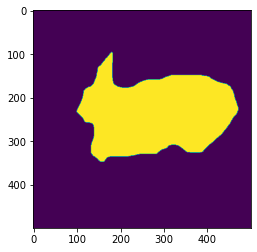

In [76]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(np.expand_dims(m[:,:,0],-1)))

In [3]:
def preprocessimg(t):
    lsttrainimg=[]
    lstsegment=[]
    for d in dataset[t]:
        im=d['image'].numpy()
        im=im/255
        im=tf.image.resize(im,[128,128]).numpy()
        lsttrainimg.append(im)
        v = d['segmentation_mask'].numpy()
        vnp = tf.image.resize(v,[128,128]).numpy()
        m1=np.zeros(vnp.shape)
        m1[np.nonzero(vnp==1)]=1
        m2=np.zeros(vnp.shape)
        m2[np.nonzero(vnp==2)]=1
        m3=np.zeros(vnp.shape)
        m3[np.nonzero(vnp==3)]=1
        m=np.concatenate((m1,m2,m3),axis=-1)
        lstsegment.append(m)
    X = np.array(lsttrainimg)
    Y = np.array(lstsegment)
    return X,Y

trainX,trainY = preprocessimg('train')
testX,testY = preprocessimg('test')


In [4]:
def displayimg(X,Y,i):
    plt.subplot(1,4,1)
    plt.imshow(X[i])
    plt.subplot(1,4,2)
    s1 =tf.keras.preprocessing.image.array_to_img(np.expand_dims(Y[i][:,:,0],-1))
    plt.imshow(s1)
    plt.subplot(1,4,3)
    s2 =tf.keras.preprocessing.image.array_to_img(np.expand_dims(Y[i][:,:,1],-1))
    plt.imshow(s2)
    plt.subplot(1,4,4)
    s3 = tf.keras.preprocessing.image.array_to_img(np.expand_dims(Y[i][:,:,2],-1))
    plt.imshow(s3)

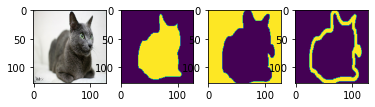

In [6]:
displayimg(testX,testY,100)

In [11]:
trainX.shape

(3680, 128, 128, 3)

In [12]:
trainY.shape

(3680, 128, 128, 3)

In [6]:
testX.shape

(3669, 128, 128, 3)

In [14]:
testY.shape

(3669, 128, 128, 3)

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),include_top=False)

In [6]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_layer_outputs = [base_model.get_layer(l).output for l in layer_names ]

In [7]:
down_model = tf.keras.Model(base_model.input,base_layer_outputs)
down_model.trainable = False

In [8]:
down_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

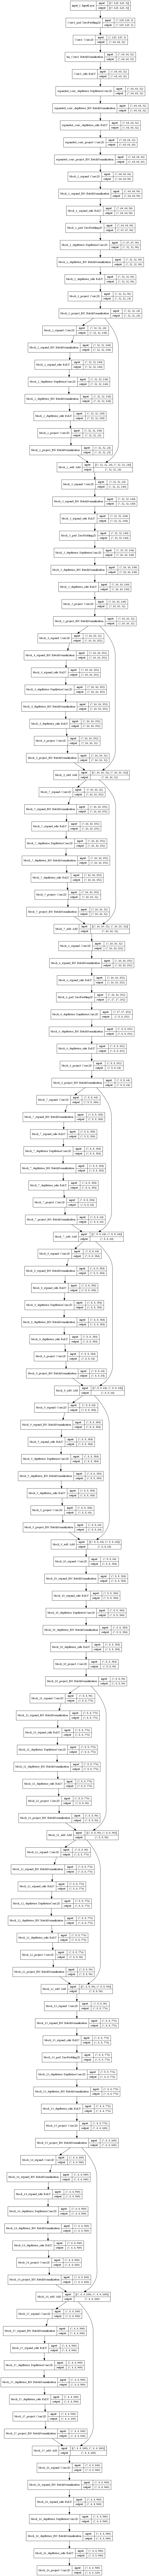

In [9]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(down_model,show_shapes=True)

In [10]:
def unet(output_channels):
    inputs = tf.keras.layers.Input(shape = [128,128,3])
    doutputs = down_model(inputs)
    x = tf.keras.layers.Conv2DTranspose(320,3,2,padding='same')(doutputs[4])
    x=tf.keras.layers.Conv2D(512,1,1,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.concatenate([x,doutputs[3]])
    x=tf.keras.layers.Conv2DTranspose(1088,3,2,padding='same')(x)
    x = tf.keras.layers.Conv2D(256,1,1,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.concatenate([x,doutputs[2]])
    x=tf.keras.layers.Conv2DTranspose(448,3,2,padding='same')(x)
    x=tf.keras.layers.Conv2D(128,1,1,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.concatenate([x,doutputs[1]])
    x=tf.keras.layers.Conv2DTranspose(272,3,2,padding='same')(x)
    x=tf.keras.layers.Conv2D(64,1,1,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.1)(x)
    x=tf.keras.layers.concatenate([x,doutputs[0]])
    x=tf.keras.layers.Conv2DTranspose(output_channels,3,2,padding='same',activation='softmax')(x)
    m=tf.keras.Model(inputs,x)
    return m

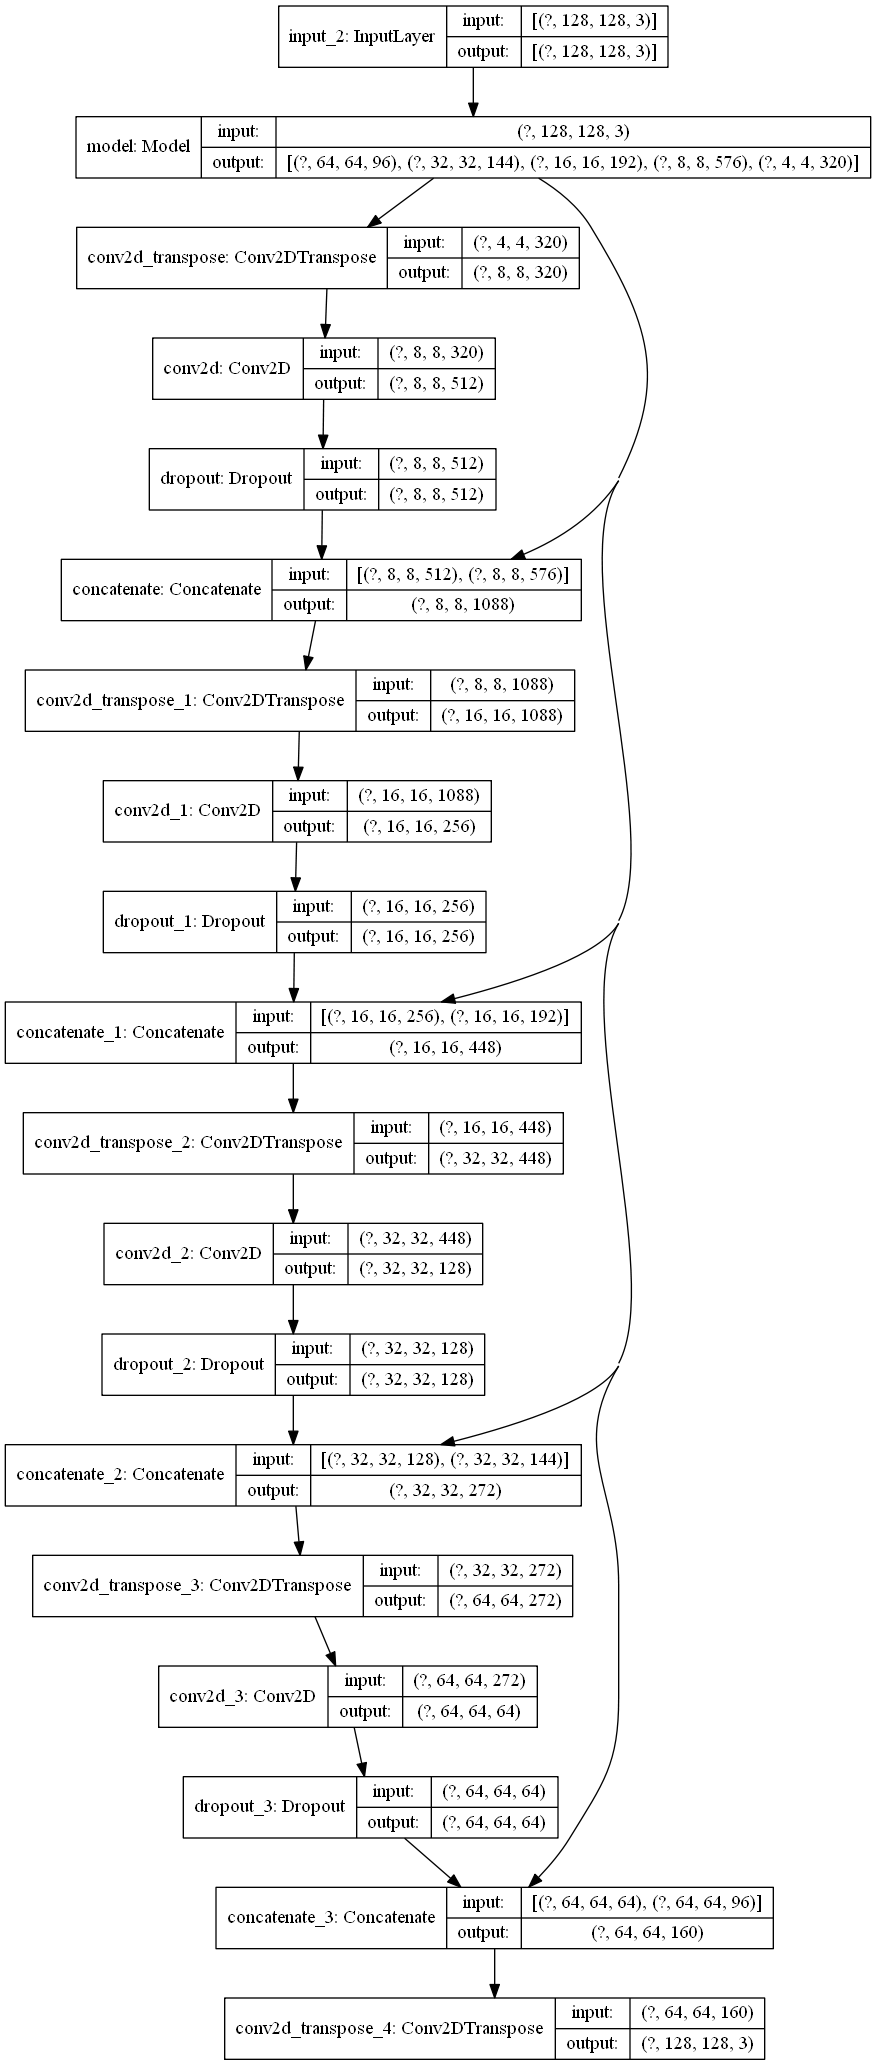

In [11]:
model = unet(3)
tf.keras.utils.plot_model(model,show_shapes=True)

In [26]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self,eps=1e-6):
        super().__init__()
        self.eps=eps
    def call(self,y_true, y_pred):
        num_dice = 2*tf.reduce_sum(tf.math.multiply(y_true,y_pred),[1,2])
        den_dice = tf.reduce_sum(y_true+y_pred,[1,2])
        dice = tf.reduce_mean((self.eps+num_dice)/(self.eps+den_dice))
        return 1-dice 

In [27]:
valindex=3000
# trainX.shape
valX = trainX[valindex:]
valY=trainY[valindex:]
tX = trainX[:valindex]
tY = trainY[:valindex]
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[tf.keras.metrics.Accuracy()])
model.compile(optimizer='adam',loss = DiceLoss(),metrics=[tf.keras.metrics.Accuracy()])

In [28]:
logdir = '.\logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
batch_size=30
spe = tf.math.ceil(valindex/batch_size)
validation_data =(valX,valY)
epochs=10
model.fit(x=tX,y=tY,batch_size=batch_size,epochs=epochs,callbacks=[tensorboard_callback],validation_data=validation_data,steps_per_epoch=spe)

Train on 3000 samples, validate on 680 samples
Epoch 1/10
3000/3000 [==============================] - 179s 60ms/sample - loss: 0.2964 - accuracy: 0.2872 - val_loss: 0.2374 - val_accuracy: 0.3612
Epoch 2/10
3000/3000 [==============================] - 179s 60ms/sample - loss: 0.2151 - accuracy: 0.4599 - val_loss: 0.2386 - val_accuracy: 0.3839
Epoch 3/10
3000/3000 [==============================] - 187s 62ms/sample - loss: 0.2061 - accuracy: 0.4963 - val_loss: 0.2280 - val_accuracy: 0.4178
Epoch 4/10
3000/3000 [==============================] - 188s 63ms/sample - loss: 0.1961 - accuracy: 0.5180 - val_loss: 0.2255 - val_accuracy: 0.4698
Epoch 5/10
3000/3000 [==============================] - 186s 62ms/sample - loss: 0.1912 - accuracy: 0.5425 - val_loss: 0.2117 - val_accuracy: 0.4990
Epoch 6/10
3000/3000 [==============================] - 173s 58ms/sample - loss: 0.1922 - accuracy: 0.5676 - val_loss: 0.2132 - val_accuracy: 0.5240
Epoch 7/10
3000/3000 [==============================] - 179

In [29]:
def displaypreds(i):
    p=model.predict(np.expand_dims(testX[i],0))
    pnp=np.argmax(p,axis=-1)
    pnp = np.expand_dims(pnp,axis=-1)
    pnp=pnp[0]
    pnp=pnp+1
    plt.subplot(1,3,1)
    plt.title('predicted mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pnp))
    plt.subplot(1,3,2)
    plt.title('test image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(testX[i]))
    plt.subplot(1,3,3)
    plt.title('True mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(testY[i]))

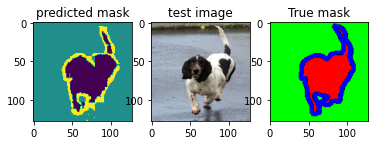

In [32]:
displaypreds(250)

In [38]:
pnp.shape

(128, 128, 1)

In [16]:
j=np.arange(9).reshape((3,3))
k=np.arange(9,18).reshape((3,3))
j*k

array([[  0,  10,  22],
       [ 36,  52,  70],
       [ 90, 112, 136]])

In [17]:
j

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [12]:
j=np.arange(48).reshape((2,2,3,4))

In [32]:
j

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]],


       [[[24, 25, 26, 27],
         [28, 29, 30, 31],
         [32, 33, 34, 35]],

        [[36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]]]])

In [15]:
k=(tf.reduce_sum(j,[2,1]))
tf.print(k)

[[60 66 72 78]
 [204 210 216 222]]


In [34]:
tf.print(tf.reduce_mean(k))

141
